# Minimum Variance Beamformer

参考论文：https://www.researchgate.net/publication/6135459_Adaptive_Beamforming_Applied_to_Medical_Ultrasound_Imaging

### 1. 生成钟组随机数据

##### (1) 基础仿真数据的生成

$ y(t)=[a + \epsilon{_1} * GN{_1}(\mu_1,\sigma_1)] + [b + \epsilon{_2} * GN{_2}(\mu_2,\sigma_2)] * t $

$ GN_{1} $ 代表钟在频率a上的噪声，$ GN_{2} $ 代表钟在频率漂移b上的噪声

$ a = μ_1 = μ_2 = 0, b = 10^{-15}, σ_1 = 2 × 10^{-30}, σ_2 = 10^{-34}, t = 1, 2, 3... $

In [1]:
a = 0
b = 10 ** (-15)
epsilon_1 = 1.0
epsilon_2 = 0.1
mu_1 = 0
mu_2 = 0
sigma_1 = 2 * 10 ** (-30)
sigma_2 = 10 ** (-34)

t = range(1,11) # 1,2,3...10
clock_size = 5

In [2]:
import math
import numpy as np
frequency = a + epsilon_1 * np.random.normal(loc=mu_1, scale=math.sqrt(sigma_1), size=(len(t), clock_size))
frequency_drift = b + epsilon_2 * np.random.normal(loc=mu_2, scale=math.sqrt(sigma_2), size=(len(t), clock_size))

In [3]:
y_t = frequency + np.array(t).reshape((-1,1)) * frequency_drift
print(y_t)

[[ 1.27502855e-15 -1.57073789e-17 -6.61784370e-16 -1.10697953e-15
   6.87851724e-16]
 [ 2.77013984e-15  3.57885521e-15  1.48668519e-15  3.78822443e-15
   1.08170775e-15]
 [ 2.57126587e-15  4.36428714e-15  4.01554447e-15  3.42511647e-15
   4.52332308e-15]
 [ 4.11707069e-15  3.30391251e-15  2.62391223e-15  3.11648799e-15
   4.75322823e-15]
 [ 3.29415334e-15  2.05533488e-15  4.46280413e-15  4.28143835e-15
   4.04548623e-15]
 [ 4.37586826e-15  4.79130080e-15  5.51049268e-15  7.44585157e-15
   7.90352511e-15]
 [ 7.37751968e-15  8.72373846e-15  7.41317626e-15  7.08338369e-15
   7.99932670e-15]
 [ 7.64605070e-15  7.34084548e-15  6.61172200e-15  8.72062950e-15
   8.27639782e-15]
 [ 1.07785545e-14  9.79975367e-15  8.45512932e-15  7.92014807e-15
   9.75872546e-15]
 [ 9.86258011e-15  8.42306782e-15  9.16324573e-15  7.61482826e-15
   1.23089399e-14]]


##### (2) 添加相关性扰动

$ y_{i}(t) = y_{i}(t) + \beta GN_{s}, -1 < \beta < 1 $

$ GN_{s} $ 代表环境产生的噪声。β表示相关性的大小，用它来控制钟之间的相关性

In [4]:
mu_s = 0
sigma_s = 10 ** (-30)
beta = np.random.uniform(-1.0, 1.0, clock_size)
noice_global = np.random.normal(loc=mu_s, scale=math.sqrt(sigma_s), size=(len(t), 1))

print(beta)
print(noice_global)

[0.02932499 0.07993378 0.1482538  0.97527107 0.27706066]
[[ 5.98298539e-16]
 [ 1.21134037e-15]
 [-5.72753709e-17]
 [-6.96383913e-16]
 [-4.68209691e-16]
 [-1.31883185e-15]
 [ 2.61580803e-17]
 [ 4.57489824e-16]
 [ 2.45125898e-16]
 [ 5.74013790e-16]]


In [5]:
y_t = y_t + noice_global * beta
print(y_t)

[[ 1.29257364e-15  3.21168824e-17 -5.73084336e-16 -5.23476275e-16
   8.53616712e-16]
 [ 2.80566238e-15  3.67568222e-15  1.66627101e-15  4.96960965e-15
   1.41732251e-15]
 [ 2.56958627e-15  4.35970890e-15  4.00705318e-15  3.36925746e-15
   4.50745433e-15]
 [ 4.09664924e-15  3.24824792e-15  2.52067067e-15  2.43732490e-15
   4.56028764e-15]
 [ 3.28042310e-15  2.01790911e-15  4.39339027e-15  3.82480698e-15
   3.91576374e-15]
 [ 4.33719353e-15  4.68588159e-15  5.31497084e-15  6.15963302e-15
   7.53812868e-15]
 [ 7.37828676e-15  8.72582937e-15  7.41705430e-15  7.10889491e-15
   8.00657407e-15]
 [ 7.65946659e-15  7.37741437e-15  6.67954661e-15  9.16680609e-15
   8.40315025e-15]
 [ 1.07857428e-14  9.81934751e-15  8.49147017e-15  8.15921226e-15
   9.82664020e-15]
 [ 9.87941306e-15  8.46895091e-15  9.24834546e-15  8.17464730e-15
   1.24679765e-14]]


##### (3) 可视化各台钟的数据

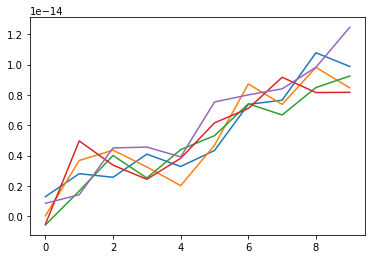

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(facecolor='white')
plt.plot(y_t)
plt.show()

### 2. 安装Allan Variance组件包

In [7]:
# https://allantools.readthedocs.io/en/latest/functions.html
!pip install allantools
import allantools

You should consider upgrading via the 'pip install --upgrade pip' command.


### 3. 生成子钟组

In [8]:
subset_size = 3
subsets = list()
if subset_size > y_t.shape[1]:
    raise Exception('The subset size should not be greater than the number of clocks')
for i in range(y_t.shape[1] - subset_size + 1):
    subset = y_t[:,i:i+subset_size]
    subsets.append(subset)
print(subsets)

[array([[ 1.29257364e-15,  3.21168824e-17, -5.73084336e-16],
       [ 2.80566238e-15,  3.67568222e-15,  1.66627101e-15],
       [ 2.56958627e-15,  4.35970890e-15,  4.00705318e-15],
       [ 4.09664924e-15,  3.24824792e-15,  2.52067067e-15],
       [ 3.28042310e-15,  2.01790911e-15,  4.39339027e-15],
       [ 4.33719353e-15,  4.68588159e-15,  5.31497084e-15],
       [ 7.37828676e-15,  8.72582937e-15,  7.41705430e-15],
       [ 7.65946659e-15,  7.37741437e-15,  6.67954661e-15],
       [ 1.07857428e-14,  9.81934751e-15,  8.49147017e-15],
       [ 9.87941306e-15,  8.46895091e-15,  9.24834546e-15]]), array([[ 3.21168824e-17, -5.73084336e-16, -5.23476275e-16],
       [ 3.67568222e-15,  1.66627101e-15,  4.96960965e-15],
       [ 4.35970890e-15,  4.00705318e-15,  3.36925746e-15],
       [ 3.24824792e-15,  2.52067067e-15,  2.43732490e-15],
       [ 2.01790911e-15,  4.39339027e-15,  3.82480698e-15],
       [ 4.68588159e-15,  5.31497084e-15,  6.15963302e-15],
       [ 8.72582937e-15,  7.41705430e

### 4. 在滑动窗口内计算协方差矩阵，并计算各子钟组权重

------------------Step 0------------------
*** Raw sum ***
[7.51606190e-16 8.14761561e-15 1.09363484e-14 9.86556782e-15
 9.69172247e-15]
*** Raw sum ***
[-1.06444373e-15  1.03115629e-14  1.17360195e-14  8.20624349e-15
  1.02361064e-14]
*** Raw sum ***
[-2.42943899e-16  8.05320317e-15  1.18837650e-14  9.51828321e-15
  1.21339610e-14]
*** Cov mean ***
[[5.62097411e-30 6.75933385e-30 6.76245780e-30]
 [6.75933385e-30 8.87016669e-30 8.25519227e-30]
 [6.76245780e-30 8.25519227e-30 8.50540955e-30]]
*** Inverse Cov mean ***
[[ 5.01007088e+30 -1.14365545e+30 -2.87338277e+30]
 [-1.14365545e+30  1.42679495e+30 -4.75526184e+29]
 [-2.87338277e+30 -4.75526184e+29  2.86367043e+30]]
*** Weight ***
[[ 3.14841218]
 [-0.60996238]
 [-1.5384498 ]]
*** Weighted output ***
[1.12979790e-15 2.32431266e-15 2.99700870e-15 3.80399106e-15
 1.86746914e-15]
------------------Step 1------------------
*** Raw sum ***
[8.14761561e-15 1.09363484e-14 9.86556782e-15 9.69172247e-15
 1.43380460e-14]
*** Raw sum ***
[1.03115

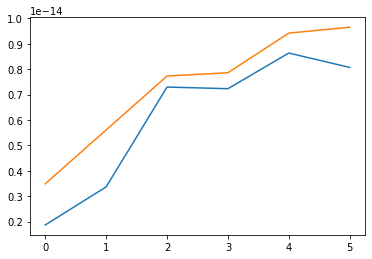

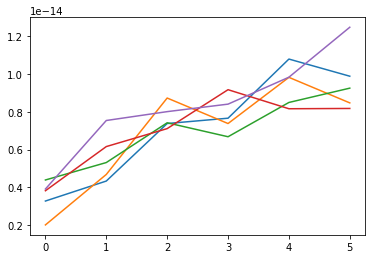

*** Weighted clock's Allan Variance ***
taus - [1.], adevs - [1.86774738e-15]
*** Mean clock's Allan Variance ***
taus - [1.], adevs - [9.85320491e-16]
*** Each clock's Allan Variance ***
taus - [1.], adevs - [2.11870078e-15]
taus - [1.], adevs - [2.73096306e-15]
taus - [1.], adevs - [1.46071863e-15]
taus - [1.], adevs - [1.30349531e-15]
taus - [1.], adevs - [1.24950367e-15]


In [19]:
window_size = 5
window_step = 1
A = np.ones((clock_size - subset_size + 1, 1))

if window_size > y_t.shape[0]:
    raise Exception('The window size should not be greater than the number of time points')

    
weighted_clock_estimation = []
for i in range(int((y_t.shape[0] - window_size) / window_step) + 1):
    subset_raw_sum_list = list()
    print("------------------Step %s------------------" % i)
    for j in range(len(subsets)):
        # 1. Get raw subset
        subset_raw = subsets[j][i:i+window_size,]
        
        # 2. Calculate summation within a subset 
        subset_raw_sum = np.sum(subset_raw, axis=1)
        subset_raw_sum_list.append(subset_raw_sum)
        print("*** Raw sum ***")
        print(subset_raw_sum)
   
    # 3. Calculate covariance matrix mean (Element-wise)
    print("*** Cov mean ***")
    allset_cov_mean = np.cov(np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1)
    print(allset_cov_mean)
    
    # 4. Calculate the inverse of covariance matrix mean
    print("*** Inverse Cov mean ***")
    allset_cov_mean_inverse = np.linalg.inv(allset_cov_mean)
    print(allset_cov_mean_inverse)
    
    # 5. Calculate weight
    print("*** Weight ***")
    weight = np.dot(allset_cov_mean_inverse, A) / np.dot(np.dot(A.T, allset_cov_mean_inverse), A)
    print(weight)

    # 6. Calculate weighted clock
    print("*** Weighted output ***")
    Z = (np.dot(weight.T, np.asarray(subset_raw_sum_list)) / (clock_size - subset_size + 1))[0]
    print(Z)
    
    # 7. Select the last element in Z as the estimation of weighted clock
    weighted_clock_estimation.append(Z[-1])
    
# 8. Visualize weighted clock estimation and each clock
print("------------------Overall------------------")
print("*** Weighted clock estimation ***")
print(weighted_clock_estimation)

real_clock = y_t[-(int((y_t.shape[0] - window_size) / window_step) + 1):,]
real_clock_mean = np.mean(real_clock, axis=1)
print("*** Mean clock estimation ***")
print(real_clock_mean)

print("*** Clock covariance matrix ***")
print(np.cov(real_clock.T))

fig = plt.figure(facecolor='white')
plt.plot(weighted_clock_estimation)
plt.plot(real_clock_mean)
plt.show()

fig = plt.figure(facecolor='white')
plt.plot(real_clock)
plt.show()

# 9. Calculate Allan variance
print("*** Weighted clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(weighted_clock_estimation)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Mean clock's Allan Variance ***")
(taus, adevs, errors, ns) = allantools.adev(real_clock_mean)
print('taus - %s, adevs - %s' % (taus, adevs))

print("*** Each clock's Allan Variance ***")
for i in range(real_clock.shape[1]):
    (taus, adevs, errors, ns) = allantools.adev(real_clock[:,i])
    print('taus - %s, adevs - %s' % (taus, adevs))

### 计算R(n)的估计
$ \hat{R}(n)=\frac{1}{(2K+1)(M-L+1)}\sum_{k=-K}^K\sum_{l=0}^{M-L}\bar{X_l}(n-k)\bar{X_l}(n-k)^{H} $